# Implementación WCEP para el problema de la mochila (relajado para que sea lineal)

Paper: Counterfactual explanations for linear optimization


In [1]:
import os

os.environ["GRB_LICENSE_FILE"] = r"C:\Users\PC2\OneDrive\Desktop\gurobi.lic"

import gurobipy as gp
from gurobipy import GRB

## Forward problem 

Inicialmente, tiene 5 variables x = (x1, x2, x3, x4, x5)

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

def generate_and_solve_knapsack_forward(n_items, seed=42):
    """
    Genera y resuelve una instancia de la Mochila Continua.
    Retorna:
        - c_hat (antes v): Peso
        - a_hat: Valor
        - b_hat: valor minimo
        - x_hat, lambda_hat, mu_hat: Solución primal y dual
        - obj_val: Valor óptimo total (c * x)
    """
    np.random.seed(seed)
    
    # 1. Generar Datos
    # Notación: c (beneficio/costo), w (peso)
    a_hat = np.random.uniform(1, 10, n_items)
    c_hat = np.random.uniform(1, 25, n_items) # Antes 'values'
    
    # Capacidad ajustada 
    b_hat = np.random.uniform(5* n_items, 25 * n_items)
    
    # 2. Modelo Gurobi (FORWARD)
    m = gp.Model("Knapsack_Forward")
    m.Params.OutputFlag = 0 
    
    x = m.addVars(n_items, lb=0.0, ub=1.0, name="x")
    
    # Maximizar c^T x
    m.setObjective(gp.quicksum(c_hat[j] * x[j] for j in range(n_items)), GRB.MINIMIZE)

    # Restricción Capacidad (a^T x >= b)
    cap_constr = m.addConstr(gp.quicksum(a_hat[j] * x[j] for j in range(n_items)) >= b_hat, name="Capacity")

    m.optimize()
    
    # 3. Extraer Resultados
    x_val = np.array([x[j].X for j in range(n_items)])
    lambda_val = cap_constr.Pi  # Precio sombra de la capacidad
    
    # Cálculo de mu (Beneficio reducido / Ganancia neta)
    # KKT: mu = max(0, c - lambda*w)
    mu_val = np.minimum(0, c_hat - (lambda_val * a_hat))
    
    return c_hat, a_hat, b_hat, x_val, lambda_val, mu_val, m.ObjVal

# =========================================================
# EJECUCIÓN (SOLO FORWARD)
# =========================================================
n = 5
c_hat, a_hat, b_hat, x_hat, lam_hat, mu_hat, obj_val = generate_and_solve_knapsack_forward(n, seed=42)

print(f"=== PROBLEMA FORWARD (N={n}) ===")
print(f"Capacidad (b): {b_hat:.2f} | Costo del Espacio (Lambda): {lam_hat:.4f}")
print("-" * 85)
print(f"{'Item':<5} | {'Peso (a)':<10} | {'Valor (c)':<10} | {'Costo Espacio':<15} | {'Mu (Gain)':<15} | {'x':<5}")
print("-" * 85)

for j in range(n):
    # Costo que cobra la mochila por guardar este item
    cost_space = lam_hat * a_hat[j]
    
    # Etiquetas para entender qué pasó
    mark = ""
    if x_hat[j] < 0.001: 
        mark = " <-- NO ELEGIDO"
    elif 0.001 < x_hat[j] < 0.999: 
        mark = " <-- SPLIT (Item Marginal)"
    
    print(f"{j:<5} | {a_hat[j]:<10.2f} | {c_hat[j]:<10.2f} | {cost_space:<15.2f} | {mu_hat[j]:<15.2f} | {x_hat[j]:<5.2f}{mark}")

print("-" * 85)
print(f"VALOR ÓPTIMO TOTAL (c*x): {obj_val:.4f}")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2653481
Academic license 2653481 - for non-commercial use only - registered to to___@ug.uchile.cl
=== PROBLEMA FORWARD (N=5) ===
Capacidad (b): 27.06 | Costo del Espacio (Lambda): 2.8714
-------------------------------------------------------------------------------------
Item  | Peso (a)   | Valor (c)  | Costo Espacio   | Mu (Gain)       | x    
-------------------------------------------------------------------------------------
0     | 4.37       | 4.74       | 12.55           | -7.81           | 1.00 
1     | 9.56       | 2.39       | 27.44           | -25.05          | 1.00 
2     | 7.59       | 21.79      | 21.79           | 0.00            | 0.89  <-- SPLIT (Item Marginal)
3     | 6.39       | 15.43      | 18.34           | -2.92           | 1.00 
4     | 2.40       | 17.99      | 6.90            | 0.00            | 0.00  <-- NO ELEGIDO
-------------------------------------------------------------

## WCEP para una instancia en particular

Iniciando experimento WCEP (5 runs)...
Restricción: Items [0, 1, 2] son INMUTABLES (Singletons).
Run 0 | Target: Item 0 (Original x=0.00)
Run 1 | Target: Item 0 (Original x=0.00)
Run 2 | Target: Item 0 (Original x=0.00)
Run 3 | Target: Item 4 (Original x=0.00)
Run 4 | Target: Item 3 (Original x=0.00)

RESULTADOS FINALES
   Run  Target    Status       Time  SanityCheck
0    0       0  Feasible  10.079053         True
1    1       0  Feasible   0.068852         True
2    2       0  Feasible   0.125777         True
3    3       4  Feasible   0.349011         True
4    4       3  Feasible   0.099264         True


C:\Users\felip\AppData\Local\Temp\ipykernel_39140\3546260694.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=status_counts, x="Status", y="Count", ax=axes[1], palette={"Feasible":"green", "Infeasible":"red"})


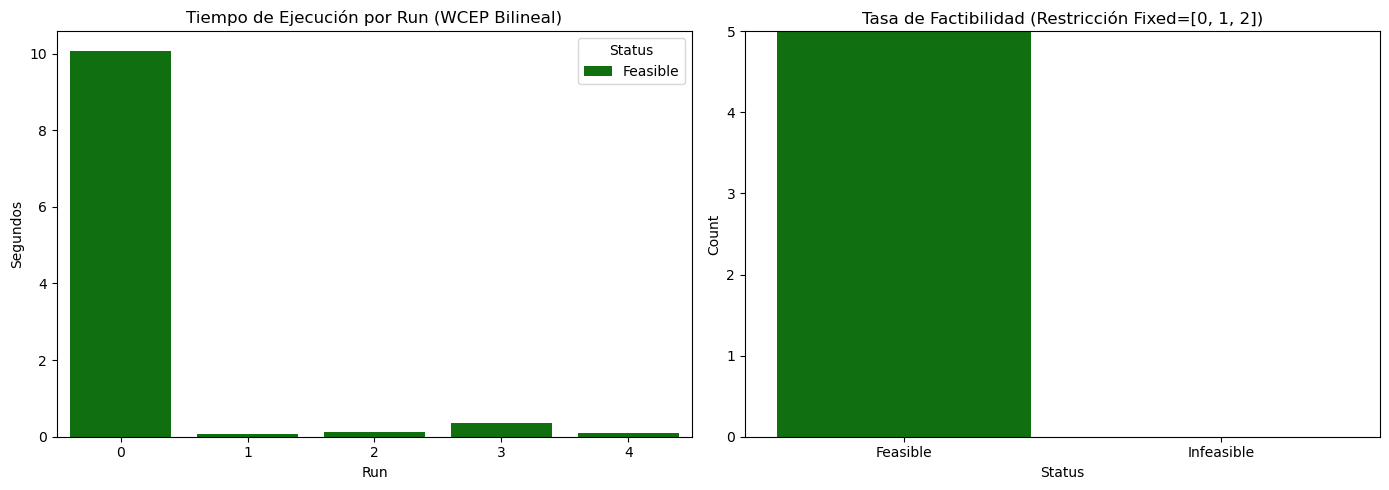

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 1. HELPER: RESOLVER FORWARD (Estándar)
# =========================================================
def solve_forward_standard(c, a, b):
    """Resuelve la mochila continua estándar dados parámetros fijos."""
    n = len(c)
    m = gp.Model("Forward_Check")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    
    m.optimize()
    
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. SOLVER WCEP CON "SINGLETONS"
# =========================================================
def solve_wcep_constrained(c_hat, a_hat, b_hat, target_idx, fixed_indices, mutable_Param):
    n = len(c_hat)
    model = gp.Model("WCEP_Constrained")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2  # ¡CRÍTICO! Habilita restricciones cuadráticas
    model.Params.TimeLimit = 20
    
    # --- VARIABLES ---
    # Parámetros modificables (c, a, b)
    c = model.addVars(n, lb=1.0, ub=25, name="c")
    a = model.addVars(n, lb=1.0, ub=10, name="a")
    #-----------------H
    

    # Variables de Certificación (Primal x, Dual lam, mu)
    x = model.addVars(n, lb=0.0, ub=10.0, name="x")
    lam = model.addVar(lb=0.0, name="lambda")
    mu = model.addVars(n, lb=0.0, name="mu")
    
    # --- RESTRICCIONES DE SINGLETONS (H_j fijo) ---
    # Para los índices fijos, forzamos igualdad estricta con el original
    if mutable_Param == 'c':
        for j in fixed_indices:
            model.addConstr(c[j] == c_hat[j], name=f"Fix_c_{j}")
        for j in range(n):
            model.addConstr(a[j] == a_hat[j], name=f"Fix_a_{j}")
        model.addConstr(b == b_hat, name="Fix_b")
    elif mutable_Param == 'a':
        for j in fixed_indices:
            model.addConstr(a[j] == a_hat[j], name=f"Fix_a_{j}")
        for j in range(n):
            model.addConstr(c[j] == c_hat[j], name=f"Fix_c_{j}")
        model.addConstr(b == b_hat, name="Fix_b")
    elif mutable_Param == 'b':
        H = len(fixed_indices)
        b = model.addVar(lb=(25*(n-H)), ub=(25*(n+H)), name="b")
        for j in range(n):
            model.addConstr(c[j] == c_hat[j], name=f"Fix_c_{j}")
            model.addConstr(a[j] == a_hat[j], name=f"Fix_a_{j}")
    else:
        for j in fixed_indices:
            model.addConstr(c[j] == c_hat[j], name=f"Fix_c_{j}")
            model.addConstr(a[j] == a_hat[j], name=f"Fix_a_{j}")
        model.addConstr(b == b_hat, name="Fix_b")
        
    # Acotamos los variables (para que no se vayan a infinito)
    for j in range(n):
        if j not in fixed_indices:
            model.addConstr(c[j] <= c_hat[j]*3) # Cota laxa
            model.addConstr(a[j] <= a_hat[j]*3)
    model.addConstr(b <= b_hat*3)

    # --- KKT / TEOREMA 19 ---
    # 1. Primal Feasibility (Bilineal)
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) <= b)
    
    # 2. Dual Feasibility (Bilineal)
    for j in range(n):
        model.addConstr(lam * a[j] + mu[j] >= c[j])
        
    # 3. Strong Duality (Forzar Optimalidad)
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam + gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj >= d_obj) # Gap 0
    
    # --- CONTRAFACTUAL ---
    model.addConstr(x[target_idx] == 1.0)
    
    # --- OBJETIVO (Distancia L1) ---
    dist = 0
    # Solo sumamos distancia de los NO fijos (los fijos suman 0)
    for j in range(n):
        if j not in fixed_indices:
            dist += (c[j] - c_hat[j])*(c[j] - c_hat[j]) # Usamos L2 prox cuadratico para suavidad
            dist += (w[j] - w_hat[j])*(w[j] - w_hat[j])
            # Nota: Usamos Cuadrático aqui (L2) para ayudar al solver no-convexo, 
            # L1 con abs() añade variables binarias que lo hacen más lento.
            
    dist += (K - K_hat)*(K - K_hat)
    
    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    
    if model.Status == GRB.OPTIMAL:
        # Extraer valores limpios
        c_new = np.array([c[j].X for j in range(n)])
        w_new = np.array([w[j].X for j in range(n)])
        K_new = K.X
        x_wcep = np.array([x[j].X for j in range(n)])
        obj_wcep = sum(c_new * x_wcep)
        return True, c_new, w_new, K_new, x_wcep, obj_wcep
    else:
        return False, None, None, None, None, None

# =========================================================
# 3. EXPERIMENTO: 5 RUNS
# =========================================================
NUM_RUNS = 5
N_ITEMS = 5
FIXED_IDXS = [0, 1, 2] # H1, H2, H3 son singletons

results = []

print(f"Iniciando experimento WCEP ({NUM_RUNS} runs)...")
print(f"Restricción: Items {FIXED_IDXS} son INMUTABLES (Singletons).")
print("="*80)

for r in range(NUM_RUNS):
    seed = 42 + r*100
    np.random.seed(seed)
    
    # 1. Generar Datos Forward Originales
    w_hat = np.random.uniform(5, 20, N_ITEMS)
    c_hat = np.random.uniform(10, 100, N_ITEMS)
    K_hat = np.sum(w_hat) * 0.45
    
    # Resolver original para encontrar un target
    orig_obj, x_orig = solve_forward_standard(c_hat, w_hat, K_hat)
    
    # Buscar Target (el primer item que tenga x=0)
    target = -1
    for j in range(N_ITEMS):
        if x_orig[j] < 0.01:
            target = j
            break
            
    if target == -1:
        print(f"Run {r}: Todos los items seleccionados. Saltando.")
        continue
        
    print(f"Run {r} | Target: Item {target} (Original x={x_orig[target]:.2f})")
    
    # 2. Ejecutar WCEP
    t0 = time.time()
    feasible, c_new, w_new, K_new, x_wcep, obj_wcep = solve_wcep_constrained(c_hat, w_hat, K_hat, target, FIXED_IDXS)
    exec_time = time.time() - t0
    
    status = "Infeasible"
    check_pass = False
    
    if feasible:
        status = "Feasible"
        
        # 3. SANITY CHECK (Prop. 3)
        # Resolvemos el problema forward real con los nuevos parametros
        check_obj, check_x = solve_forward_standard(c_new, w_new, K_new)
        
        # Comparamos Objetivo WCEP vs Objetivo Real
        # Tolerancia pequeña por errores numéricos
        if abs(obj_wcep - check_obj) < 1e-3:
            check_pass = True
            
        # Debug print
        # print(f"   -> WCEP Obj: {obj_wcep:.4f} | Check Obj: {check_obj:.4f} | Match? {check_pass}")
        
    results.append({
        "Run": r,
        "Target": target,
        "Time": exec_time,
        "Status": status,
        "SanityCheck": check_pass
    })

# =========================================================
# 4. REPORTE Y VISUALIZACIÓN
# =========================================================
df = pd.DataFrame(results)

print("\n" + "="*80)
print("RESULTADOS FINALES")
print("="*80)
print(df[["Run", "Target", "Status", "Time", "SanityCheck"]])

# --- GRÁFICOS ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Tiempos de Ejecución
sns.barplot(data=df, x="Run", y="Time", hue="Status", ax=axes[0], palette={"Feasible":"green", "Infeasible":"red"})
axes[0].set_title("Tiempo de Ejecución por Run (WCEP Bilineal)")
axes[0].set_ylabel("Segundos")

# 2. Conteo de Factibilidad
status_counts = df["Status"].value_counts().reset_index()
status_counts.columns = ["Status", "Count"]
# Asegurar que existan ambas categorías para el color
for s in ["Feasible", "Infeasible"]:
    if s not in status_counts["Status"].values:
        new_row = pd.DataFrame({"Status":[s], "Count":[0]})
        status_counts = pd.concat([status_counts, new_row], ignore_index=True)

sns.barplot(data=status_counts, x="Status", y="Count", ax=axes[1], palette={"Feasible":"green", "Infeasible":"red"})
axes[1].set_title(f"Tasa de Factibilidad (Restricción Fixed={FIXED_IDXS})")
axes[1].set_ylim(0, NUM_RUNS)

plt.tight_layout()
plt.show()

# WCEP manteniendo H fijo y variando la dimensionalidad de x

## WCEP manteniendo x fijo y variando la dimensionalidad del H